In [206]:
from keras.applications.resnet import ResNet50
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.metrics import CosineSimilarity
from keras.layers import Input
import numpy as np
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.layers import Flatten
from keras.layers import GlobalAveragePooling2D
from keras.models import Model
from keras.models import Sequential

In [207]:
def normalize_pixels(image):
    """normalize pixels to be between -1 and 1"""

	# convert from integers to floats
    image_norm = image.astype('float32')
	# normalize to range -1 and 1
    image_norm = (image_norm - 127.5) / 127.5

	# return normalized images
    return image_norm

def normalize_pixels_from_to(image, _from_min = 0, _from_max = 255, _to_min = 0, _to_max = 1):
    """normalize pixels to be between _from_max and _from_min"""

    # Normalize between 0 and 1
    image_norm = (image - _from_min) / (_from_max - _from_min)

    # Normalize between 0 and 1
    image_norm = image_norm*(_to_max - _to_min) + _to_min 

    return image_norm

def de_normalize_pixels(image, _from = 0, _to = 1):
    """de-normalize pixels to be between 0 and 255"""

    # Normalize between 0 and 1
    image_de_norm = (image * 127.5) + 127.5

    # Normalize between 0 and 1
    image_de_norm = image_de_norm/255 

    # Normalize between _from and _to
    image_de_norm = (image_de_norm * (_to - _from)) + _from
    
    return image_de_norm

def load_image(path):
    """load image from path and convert to array"""

    img = load_img(path, target_size=(224, 224), interpolation='bilinear')
    x = img_to_array(img)
    x = normalize_pixels(x)
    x = np.expand_dims(x, axis=0)
    return x

def load_image_norm(path, _min = 0, _max = 1):
    """load image from path and convert to array"""

    img = load_img(path, target_size=(224, 224), interpolation='bilinear')
    x = img_to_array(img)
    x = normalize_pixels_from_to(x, _to_min=_min, _to_max=_max)
    x = np.expand_dims(x, axis=0)
    return x

def unison_shuffled_copies(a, b):
    """shuffle two arrays in unison"""

    np.random.seed(42)

    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def pairwise_euclidean_distance(vects):
    x, y = vects
    return K.square(x - y)

def euclidean_distance(vects):
    euclidean_distance(vects[0], vects[1])
    
def euclidean_distance(x, y):
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


In [208]:
# Variables

DATA_PATH = './data/dataset_pairs'
DATA_TRAIN_SPLIT = 0.8
DATA_VALIDATION_SPLIT = 0.1
# The TEST split will be the remaining of the two splits

#amount_of_positive_pairs_per_class = 50

In [209]:
# Load images into arrays
import pathlib

data_dir = pathlib.Path(DATA_PATH)

image_count = len(list(data_dir.glob('*/*.jpg')) + list(data_dir.glob('*/*.jpeg')) + list(data_dir.glob('*/*.png')))
print("Total amount of images: " + str(image_count))

folders = [x for x in data_dir.iterdir() if x.is_dir()]

img_array_data = []

for i, folder in enumerate(folders):
    img_array_data.append([])

    for j, img in enumerate(folder.iterdir()):
        img_array_data[i].append(load_image_norm(img, 0, 1))

Total amount of images: 354


In [210]:
def create_pairs(images):
    data = []
    labels = []

    for i, array in enumerate(images):
        for j in range(len(array)):
            data.append([
                array[j],
                array[(j + 1) % len(array)]
            ])
            labels.append(1)

            random_class_index = i
            # Requires more than 1 folder
            while random_class_index == i:
                random_class_index = np.random.randint(0, len(images))

            data.append([
                array[j],
                images[random_class_index][np.random.randint(0, len(images[random_class_index]))]
            ])
            labels.append(0)

    return data, labels

data, labels = create_pairs(img_array_data)

data = np.array(data)
labels = np.array(labels)

In [211]:
# Shuffle Dataset
data, labels = unison_shuffled_copies(data, labels)

show_amount = 10
print(data[:show_amount])
print(labels[:show_amount])

[[[[[[0.654902   0.6509804  0.67058825]
     [0.68235296 0.6784314  0.69803923]
     [0.7137255  0.70980394 0.7294118 ]
     ...
     [0.78431374 0.8        0.8039216 ]
     [0.8039216  0.81960785 0.8156863 ]
     [0.8235294  0.8392157  0.8352941 ]]

    [[0.68235296 0.6784314  0.69803923]
     [0.7019608  0.69803923 0.7176471 ]
     [0.7176471  0.7137255  0.73333335]
     ...
     [0.8        0.8156863  0.81960785]
     [0.8039216  0.81960785 0.8235294 ]
     [0.80784315 0.8235294  0.827451  ]]

    [[0.72156864 0.7176471  0.7372549 ]
     [0.7294118  0.7254902  0.74509805]
     [0.7294118  0.7254902  0.74509805]
     ...
     [0.8117647  0.827451   0.8392157 ]
     [0.80784315 0.8235294  0.827451  ]
     [0.79607844 0.8117647  0.8156863 ]]

    ...

    [[0.76862746 0.79607844 0.8352941 ]
     [0.81960785 0.84705883 0.8862745 ]
     [0.8156863  0.84313726 0.88235295]
     ...
     [0.9137255  0.92941177 0.9647059 ]
     [0.9098039  0.9254902  0.9607843 ]
     [0.90588236 0.92156863 0

In [212]:
# Split data into train, validation, and test

train_split = int(DATA_TRAIN_SPLIT * len(data))
validation_split = train_split+int(DATA_VALIDATION_SPLIT * len(data))

print("TRAIN SPLIT: " + "0 - " + str(train_split) + " | " + str(train_split) + " | " + str(DATA_TRAIN_SPLIT*100) + '%')
print("VALIDATION SPLIT: " + str(train_split) + " - " + str(validation_split) + " | " + str(validation_split-train_split) + " | " + str(DATA_VALIDATION_SPLIT*100) + '%')
print("TEST SPLIT: " + str(validation_split) + " - " + str(len(data)) + " | " + str(len(data) - validation_split) + " | " + str(100 - DATA_TRAIN_SPLIT*100 - DATA_VALIDATION_SPLIT*100) + '%')

data_train = data[0:train_split]
data_validation = data[train_split:validation_split]
data_test = data[validation_split:]

labels_train = labels[0:train_split]
labels_validation = labels[train_split:validation_split]
labels_test = labels[validation_split:]

print("---")
print("Training Data Shape: " + str(data_train.shape))
print("Validation Data Shape: " + str(data_validation.shape))
print("Test Data Shape: " + str(data_test.shape))
print("---")
print("Training Labels Shape: " + str(labels_train.shape))
print("Validation Labels Shape: " + str(labels_validation.shape))
print("Test Labels Shape: " + str(labels_test.shape))

TRAIN SPLIT: 0 - 566 | 566 | 80.0%
VALIDATION SPLIT: 566 - 636 | 70 | 10.0%
TEST SPLIT: 636 - 708 | 72 | 10.0%
---
Training Data Shape: (566, 2, 1, 224, 224, 3)
Validation Data Shape: (70, 2, 1, 224, 224, 3)
Test Data Shape: (72, 2, 1, 224, 224, 3)
---
Training Labels Shape: (566,)
Validation Labels Shape: (70,)
Test Labels Shape: (72,)


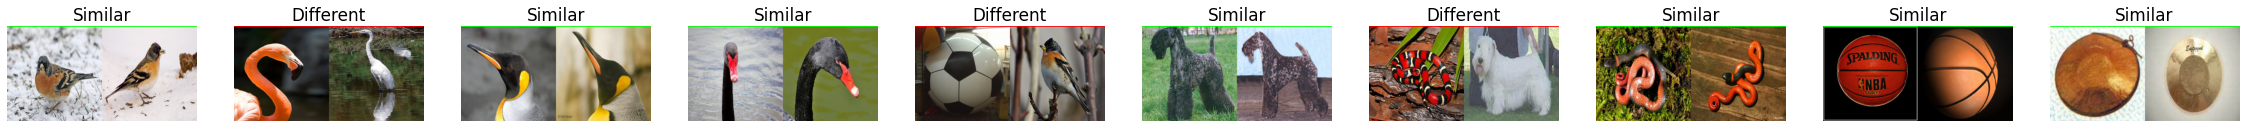

In [213]:
def visualize(pairs, labels, to_show=3, predictions=None):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """

    true_color = '#00ff00'
    false_color = '#ff0000'
    text_color = '#FFFFFF'
    scale = 2
    font_size = 14

    # Plot the images
    fig, axes = plt.subplots(1, to_show, figsize=(to_show*2*scale, 1*scale))

    plt.rcParams.update({'font.size': font_size, 'font.weight': 'bold', 'text.color': text_color})

    # Plot the pairs

    for i in range(to_show):
        axes[i].imshow((tf.concat([(pairs[i, 0, 0]), (pairs[i, 1, 0])], axis=1)), cmap='gray')

        status = "N/A"
        TP_FP_TN_FN = "N/A"
        color = '#000000'
        if labels[i] == 1: 
            status = "Similar"
            color = true_color
        if labels[i] == 0: 
            status = "Different"
            color = false_color

        axes[i].set_xticks([])
        axes[i].set_yticks([])

        axes[i].spines['top'].set_visible(True)
        axes[i].spines['top'].set_color(color)
        axes[i].spines['right'].set_visible(False)
        axes[i].spines['bottom'].set_visible(False)
        axes[i].spines['left'].set_visible(False)

        if predictions is not None:
            axes[i].set_title("{}\nPred: {:.5f}".format(status, predictions[i][0]))
        else:
            axes[i].set_title("{}".format(status))

    plt.show()

    # Plot true positives, false positives, true negatives, false negatives

visualize(data_train, labels_train, to_show=10)

In [214]:
input_shape = (224, 224, 3)

# ResNet50 Feature Extraction

resnet_input_image = Input(input_shape)

resnet_embedding = Sequential(name='resnet_embedding')
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
resnet.Trainable = False
resnet_embedding.add(resnet)
resnet_embedding.add(GlobalAveragePooling2D())

resnet_embedding_image = resnet_embedding(resnet_input_image)
resnet = Model(inputs=resnet_input_image, outputs=resnet_embedding_image)

# MobileNetV2 Feature Extraction

mobilenet_input_image = Input(input_shape)

mobilenet_embedding = Sequential(name='mobilenet_embedding')
mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
mobilenet.Trainable = False
mobilenet_embedding.add(mobilenet)
mobilenet_embedding.add(GlobalAveragePooling2D())

mobilenet_embedding_image = mobilenet_embedding(mobilenet_input_image)
mobilenet = Model(inputs=mobilenet_input_image, outputs=mobilenet_embedding_image)

In [215]:
def visualize_pair(img1, img2, _min = 0, _max = 1, scale = 2):
    fig, axes = plt.subplots(1, 1, figsize=(2*scale, 1*scale))
    axes.set_xticks([])
    axes.set_yticks([])
    plt.imshow((tf.concat([normalize_pixels_from_to(img1[0], _from_min=_min, _from_max=_max), normalize_pixels_from_to(img2[0], _from_min=_min, _from_max=_max)], axis=1)), cmap='gray')

MobileNetV2 Features Shape: (1, 1280)
Positive Similarity: 0.751
Negative Similarity: 0.464
Positive Distance: 16.185
Negative Distance: 26.716


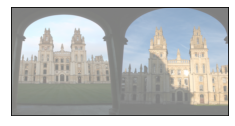

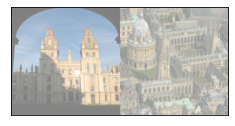

In [216]:
mobilenet_positive = load_image_norm('./data/dataset/all_souls/all_souls_000002.jpg', 0, 1)
mobilenet_anchor = load_image_norm('./data/dataset/all_souls/all_souls_000015.jpg', 0, 1)
mobilenet_negative = load_image_norm('./data/dataset/all_souls/all_souls_000180.jpg', 0, 1)
# mobilenet_negative = load_image_norm('./test_image_1.png', -1, 1)

visualize_pair(mobilenet_positive, mobilenet_anchor, -1, 1)
visualize_pair(mobilenet_anchor, mobilenet_negative, -1 ,1)

mobilenet_positive_feature = mobilenet_embedding.predict(mobilenet_positive)
mobilenet_anchor_feature = mobilenet_embedding.predict(mobilenet_anchor)
mobilenet_negative_feature = mobilenet_embedding.predict(mobilenet_negative)

print("MobileNetV2 Features Shape: " + str(mobilenet_positive_feature.shape))

positive_similarity = CosineSimilarity()(mobilenet_positive_feature, mobilenet_anchor_feature).numpy()
negative_similarity = CosineSimilarity()(mobilenet_anchor_feature, mobilenet_negative_feature).numpy()

positive_distance = euclidean_distance(mobilenet_positive_feature, mobilenet_anchor_feature).numpy()[0][0]
negative_distance = euclidean_distance(mobilenet_anchor_feature, mobilenet_negative_feature).numpy()[0][0]

print("Positive Similarity: {:.3f}".format(positive_similarity))
print("Negative Similarity: {:.3f}".format(negative_similarity))

print("Positive Distance: {:.3f}".format(positive_distance))
print("Negative Distance: {:.3f}".format(negative_distance))

Shape:  (1, 2048)
Positive Similarity: 0.996
Negative Similarity: 0.982
Positive Distance:  2.8853252
Negative Distance:  5.7448177


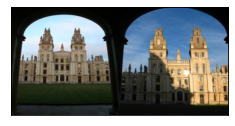

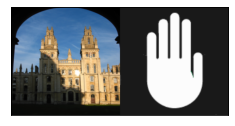

In [217]:
resnet_positive = load_image_norm('./data/dataset/all_souls/all_souls_000002.jpg', 0, 1)
resnet_anchor = load_image_norm('./data/dataset/all_souls/all_souls_000015.jpg', 0, 1)
# resnet_negative = load_image_norm('./data/dataset/radcliffe_camera/radcliffe_camera_000566.jpg', 0, 1)
resnet_negative = load_image_norm('./test_image_1.png', 0, 1)

visualize_pair(resnet_positive, resnet_anchor)
visualize_pair(resnet_anchor, resnet_negative)

resnet_positive_feature = resnet_embedding.predict(resnet_positive)
resnet_anchor_feature = resnet_embedding.predict(resnet_anchor)
resnet_negative_feature = resnet_embedding.predict(resnet_negative)

print("Shape: ", resnet_positive_feature.shape)

positive_similarity = CosineSimilarity()(resnet_positive_feature, resnet_anchor_feature).numpy()
negative_similarity = CosineSimilarity()(resnet_anchor_feature, resnet_negative_feature).numpy()

positive_distance = euclidean_distance(resnet_positive_feature, resnet_anchor_feature).numpy()[0][0]
negative_distance = euclidean_distance(resnet_anchor_feature, resnet_negative_feature).numpy()[0][0]

print("Positive Similarity: {:.3f}".format(positive_similarity))
print("Negative Similarity: {:.3f}".format(negative_similarity))

print("Positive Distance: ", positive_distance)
print("Negative Distance: ", negative_distance)

In [218]:
from dataclasses import dataclass
from enum import Enum, auto

class Contingency(Enum):
    TP = auto()
    TN = auto()
    FP = auto()
    FN = auto()

@dataclass
class OutputSet:
    img1: np.ndarray
    img2: np.ndarray
    label: int
    cosine_similarity: float
    euclidean_distance: float
    contingency: Contingency

In [219]:
# TRUE_CUTOFF = 0.5 # dynamic

# def define_contingency(prediction, label):
#     if prediction > TRUE_CUTOFF and label == 1:
#         return Contingency.TP
#     elif prediction > TRUE_CUTOFF and label == 0:
#         return Contingency.TN
#     elif prediction <= TRUE_CUTOFF and label == 1:
#         return Contingency.FP
#     elif prediction <= TRUE_CUTOFF and label == 0:
#         return Contingency.FN
#     else:
#         raise ValueError("Invalid distance and label combination")

In [220]:
def create_output_sets(_data, _labels, _embedding):
    output_sets = []
    for i in range(len(_data)):

        img1 = _data[i][0]
        img2 = _data[i][1]

        img1_features = _embedding.predict(img1)
        img2_features = _embedding.predict(img2)

        cosine = CosineSimilarity()(img1_features, img2_features).numpy()
        euclidean = euclidean_distance(img1_features, img2_features).numpy()[0][0]

        output_sets.append(OutputSet(
            img1=img1,
            img2=img2,
            label=_labels[i],
            cosine_similarity=cosine,
            euclidean_distance=euclidean,
            contingency=Contingency.TN
        ))
    return output_sets

mobilenet_output = create_output_sets(data_train, labels_train, mobilenet_embedding)
resnet_output = create_output_sets(data_train, labels_train, resnet_embedding)

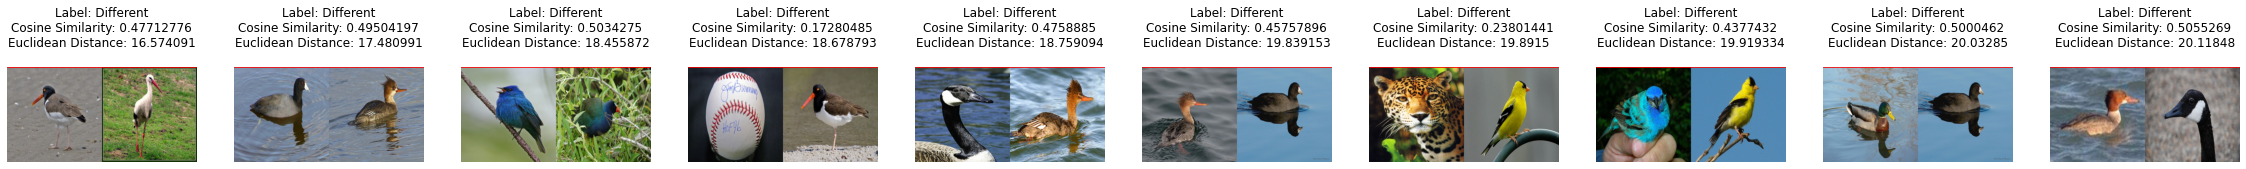

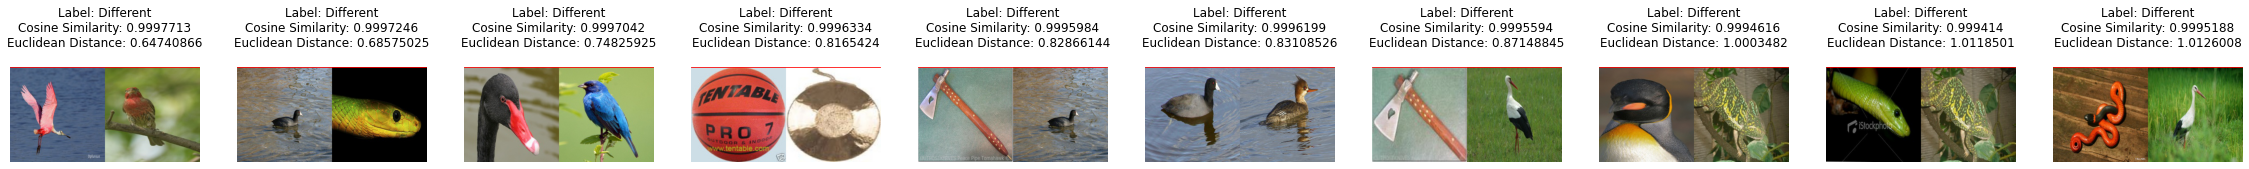

In [230]:
def visualize_output_sets(output_sets, to_show=10, offset=0):

    output_sets = output_sets[offset:offset+to_show]
    
    true_color = '#00ff00'
    false_color = '#ff0000'
    text_color = '#000000'
    scale = 2
    font_size = 5 * scale

    fig, axes = plt.subplots(1, to_show, figsize=(to_show*2*scale, 1*scale))

    plt.rcParams.update({'font.size': font_size, 'font.weight': 'bold', 'text.color': text_color})

    for i, output in enumerate(output_sets):
        
        img1 = output.img1
        img2 = output.img2
    
        axes[i].imshow((tf.concat([(img1[0]), (img2[0])], axis=1)), cmap='gray')   

        status = "N/A"
        color = '#000000'
        if output.label == 1: 
            status = "Similar"
            color = true_color
        if output.label == 0: 
            status = "Different"
            color = false_color

        axes[i].set_xticks([])
        axes[i].set_yticks([])

        axes[i].spines['top'].set_visible(True)
        axes[i].spines['top'].set_color(color)
        axes[i].spines['right'].set_visible(False)
        axes[i].spines['bottom'].set_visible(False)
        axes[i].spines['left'].set_visible(False)

        title = ""
        title += "Label: " + status + "\n"
        title += "Cosine Similarity: " + str(output.cosine_similarity) + "\n"
        title += "Euclidean Distance: " + str(output.euclidean_distance) + "\n"
        # title += "Contingency: " + str(output.contingency.name) + "\n"

        axes[i].set_title(title)

    plt.show()

mobilenet_output_x = list(mobilenet_output)
resnet_output_x = list(resnet_output)

mobilenet_output_x.sort(key=lambda x: x.euclidean_distance, reverse=False)
resnet_output_x.sort(key=lambda x: x.euclidean_distance, reverse=False)

# filter
mobilenet_output_x = [x for x in mobilenet_output_x if x.label == 0]
resnet_output_x = [x for x in resnet_output_x if x.label == 0]

visualize_output_sets(mobilenet_output_x, to_show=10, offset=0)
visualize_output_sets(resnet_output_x, to_show=10, offset=0)

In [ ]:
# TODO evaluate the models using ROC, AUC, Confusion Matrix, etc. 